Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [5]:
dataset = df['Passengers'].values.astype('float32')

dataset[:5]

array([112., 118., 132., 129., 121.], dtype=float32)

Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [6]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size

In [7]:
train = dataset[0:train_size]

test = dataset[train_size:len(dataset)]

In [8]:
print(f"Загальна кількість спостережень: {len(dataset)}")
print(f"Розмір тренувального набору (67%): {len(train)}")
print(f"Розмір валідаційного набору (33%): {len(test)}")

Загальна кількість спостережень: 144
Розмір тренувального набору (67%): 96
Розмір валідаційного набору (33%): 48


In [9]:
train[:5]

array([112., 118., 132., 129., 121.], dtype=float32)

In [10]:
test[-5:]

array([606., 508., 461., 390., 432.], dtype=float32)

**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [12]:
import torch

In [13]:
def create_dataset(dataset: np.ndarray, lookback: int = 1):
    """
    Перетворює одномірний часовий ряд у формат (ознаки X, цільові значення y),
    придатний для тренування рекурентних нейромереж.

    :param dataset: numpy-масив часового ряду.
    :param lookback: Кількість попередніх кроків, що використовуються для прогнозування.
    :return: Тензори PyTorch X та y.
    """
    dataX, dataY = [], []

    for i in range(len(dataset) - lookback):
        a = dataset[i:(i + lookback)]
        dataX.append(a)

        dataY.append(dataset[i + lookback])

    X_numpy = np.array(dataX)
    y_numpy = np.array(dataY)

    X = torch.from_numpy(X_numpy)
    y = torch.from_numpy(y_numpy)

    X = X.unsqueeze(2)

    y = y.reshape(-1, 1)

    return X, y

In [14]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [15]:
import torch.nn as nn

In [16]:
class AirModel(nn.Module):

    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(AirModel, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x має форму (batch_size, sequence_length, input_size)

        lstm_out, (h_n, c_n) = self.lstm(x)

        last_output = lstm_out[:, -1, :]

        prediction = self.linear(last_output)

        return prediction

In [17]:
hidden_size_val = 50
num_layers_val = 1
model = AirModel(
    hidden_size=hidden_size_val,
    num_layers=num_layers_val
)

In [18]:
test_input = torch.tensor([[112.0]], dtype=torch.float32).unsqueeze(2)

In [19]:
with torch.no_grad():
    prediction = model(test_input)

In [21]:
print(f"Вхідний тензор (112.0): {test_input.squeeze()}")
print(f"Форма вхідного тензора: {test_input.shape}")
print("-" * 50)
print(f"Прогноз (з рандомними вагами): {prediction.item():.4f}")
print(f"Форма прогнозного тензора: {prediction.shape}")

Вхідний тензор (112.0): 112.0
Форма вхідного тензора: torch.Size([1, 1, 1])
--------------------------------------------------
Прогноз (з рандомними вагами): 0.1144
Форма прогнозного тензора: torch.Size([1, 1])


**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [22]:
from torch.utils.data import TensorDataset, DataLoader

In [23]:
train_dataset = TensorDataset(X_train, y_train)

In [24]:
batch_size_val = 8
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size_val,
    shuffle=True
)

In [25]:
print(f"Загальна кількість тренувальних зразків: {len(X_train)}")
print(f"Розмір батчу: {batch_size_val}")
print(f"Кількість батчів у DataLoader: {len(train_loader)}")

Загальна кількість тренувальних зразків: 95
Розмір батчу: 8
Кількість батчів у DataLoader: 12


**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [27]:
import torch.optim as optim

In [29]:
def calculate_rmse(model, X, y):
    """Обчислює корінь середньоквадратичної похибки (RMSE) на даних."""
    model.eval()
    with torch.no_grad():
        predictions = model(X)
        mse = criterion(predictions, y)
        rmse = torch.sqrt(mse).item()
    model.train()
    return rmse

In [38]:
hidden_size_val = 50
num_layers_val = 1
num_epochs = 2000

model = AirModel(hidden_size=hidden_size_val, num_layers=num_layers_val)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []

In [39]:
losses = []
train_rmse_log = []
test_rmse_log = []
epochs_log = []

In [40]:
for epoch in range(num_epochs):
    epoch_losses = []

    # 1. Тренування
    for X_batch, y_batch in train_loader:

        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    avg_loss = np.mean(epoch_losses)
    losses.append(avg_loss)

    # 2. Валідація та вивід результатів
    if (epoch + 1) % 100 == 0 or epoch == 0:
        train_rmse = calculate_rmse(model, X_train, y_train)
        test_rmse = calculate_rmse(model, X_test, y_test)

        epochs_log.append(epoch + 1)
        train_rmse_log.append(train_rmse)
        test_rmse_log.append(test_rmse)

        print(f"Epoch {epoch+1:4d}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

Epoch    1: train RMSE 225.7175, test RMSE 422.1176
Epoch  100: train RMSE 189.0832, test RMSE 383.8134
Epoch  200: train RMSE 157.7592, test RMSE 350.2018
Epoch  300: train RMSE 129.8659, test RMSE 318.9081
Epoch  400: train RMSE 106.0578, test RMSE 289.8999
Epoch  500: train RMSE 87.4218, test RMSE 264.0518
Epoch  600: train RMSE 70.8121, test RMSE 239.3117
Epoch  700: train RMSE 57.5264, test RMSE 216.3178
Epoch  800: train RMSE 47.1927, test RMSE 195.5786
Epoch  900: train RMSE 39.4001, test RMSE 177.0490
Epoch 1000: train RMSE 33.8825, test RMSE 160.7738
Epoch 1100: train RMSE 30.0866, test RMSE 147.0115
Epoch 1200: train RMSE 28.0086, test RMSE 135.9883
Epoch 1300: train RMSE 26.1929, test RMSE 127.0688
Epoch 1400: train RMSE 25.2184, test RMSE 120.3923
Epoch 1500: train RMSE 25.4967, test RMSE 114.5912
Epoch 1600: train RMSE 26.2973, test RMSE 112.6618
Epoch 1700: train RMSE 24.7531, test RMSE 108.3400
Epoch 1800: train RMSE 24.2194, test RMSE 103.9984
Epoch 1900: train RMSE 24.

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

In [31]:
from matplotlib import pyplot as plt

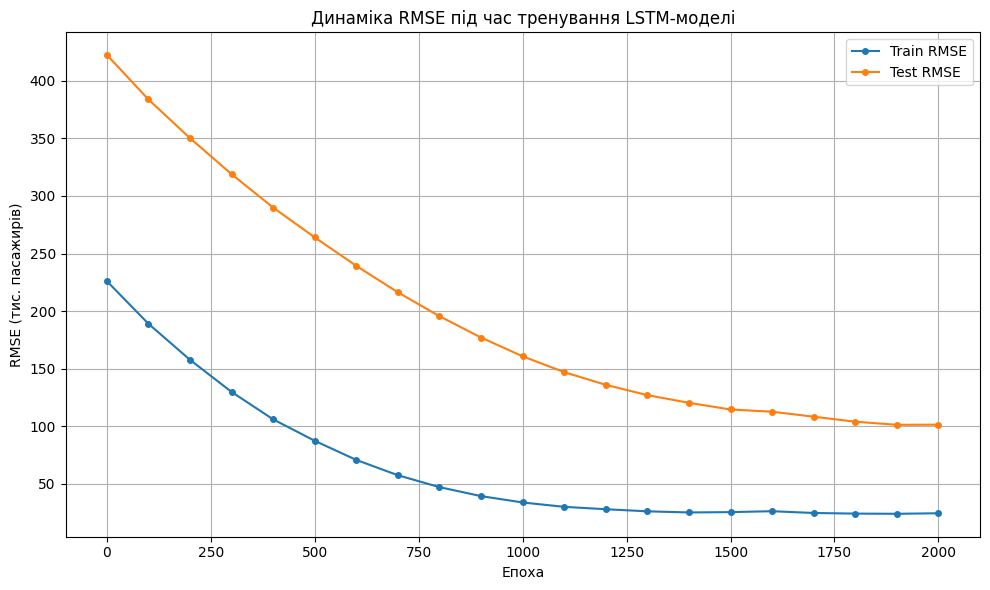

In [41]:
plt.figure(figsize=(10, 6))

plt.plot(epochs_log, train_rmse_log, label='Train RMSE', marker='o', markersize=4)
plt.plot(epochs_log, test_rmse_log, label='Test RMSE', marker='o', markersize=4)
plt.title('Динаміка RMSE під час тренування LSTM-моделі')
plt.xlabel('Епоха')
plt.ylabel('RMSE (тис. пасажирів)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Спостереження**

На основі отриманих даних і графіка ми омжемо впевнено сказати що модель навчилася, але зіткнулася з проблемою перенавчання, оскільки дані не були попередньо нормалізовані.

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

In [43]:
timeseries = df['Passengers'].values.astype('float32')

/tmp/ipython-input-311553601.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_plot[lookback:train_size] = model(X_train)[:, -1]
/tmp/ipython-input-311553601.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]


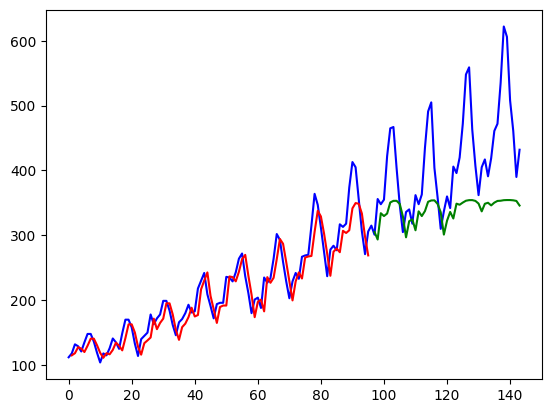

In [44]:
def plot_predicts():
  with torch.no_grad():
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_size] = model(X_train)[:, -1]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(timeseries) * np.nan
      test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]

  # Візуалізація результатів
  plt.plot(timeseries, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.show()

plot_predicts()

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [45]:
hidden_size_val = 100
num_layers_val = 1
num_epochs = 2000

In [46]:
model_100 = AirModel(hidden_size=hidden_size_val, num_layers=num_layers_val)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_100.parameters(), lr=0.001)

In [47]:
losses_100 = []
train_rmse_log_100 = []
test_rmse_log_100 = []
epochs_log_100 = []

In [48]:
for epoch in range(num_epochs):
    epoch_losses = []
    model_100.train()

    # Тренування
    for X_batch, y_batch in train_loader:
        predictions = model_100(X_batch)
        loss = criterion(predictions, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    avg_loss = np.mean(epoch_losses)
    losses_100.append(avg_loss)

    # Валідація та вивід результатів
    if (epoch + 1) % 100 == 0 or epoch == 0:
        train_rmse = calculate_rmse(model_100, X_train, y_train)
        test_rmse = calculate_rmse(model_100, X_test, y_test)

        epochs_log_100.append(epoch + 1)
        train_rmse_log_100.append(train_rmse)
        test_rmse_log_100.append(test_rmse)

        print(f"Epoch {epoch+1:4d}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

Epoch    1: train RMSE 225.6546, test RMSE 422.0500
Epoch  100: train RMSE 149.8249, test RMSE 341.4749
Epoch  200: train RMSE 100.9185, test RMSE 283.0815
Epoch  300: train RMSE 71.3687, test RMSE 239.1619
Epoch  400: train RMSE 50.7398, test RMSE 202.2621
Epoch  500: train RMSE 38.2894, test RMSE 172.7942
Epoch  600: train RMSE 31.1533, test RMSE 149.4518
Epoch  700: train RMSE 29.1697, test RMSE 132.5444
Epoch  800: train RMSE 25.1550, test RMSE 118.7411
Epoch  900: train RMSE 24.7384, test RMSE 109.3850
Epoch 1000: train RMSE 23.9201, test RMSE 103.2048
Epoch 1100: train RMSE 26.2641, test RMSE 101.0141
Epoch 1200: train RMSE 23.4504, test RMSE 95.1578
Epoch 1300: train RMSE 23.3578, test RMSE 93.7380
Epoch 1400: train RMSE 23.6154, test RMSE 90.6121
Epoch 1500: train RMSE 22.9761, test RMSE 90.0691
Epoch 1600: train RMSE 23.6667, test RMSE 90.3657
Epoch 1700: train RMSE 23.3858, test RMSE 89.6767
Epoch 1800: train RMSE 22.8882, test RMSE 86.2815
Epoch 1900: train RMSE 22.9510, tes

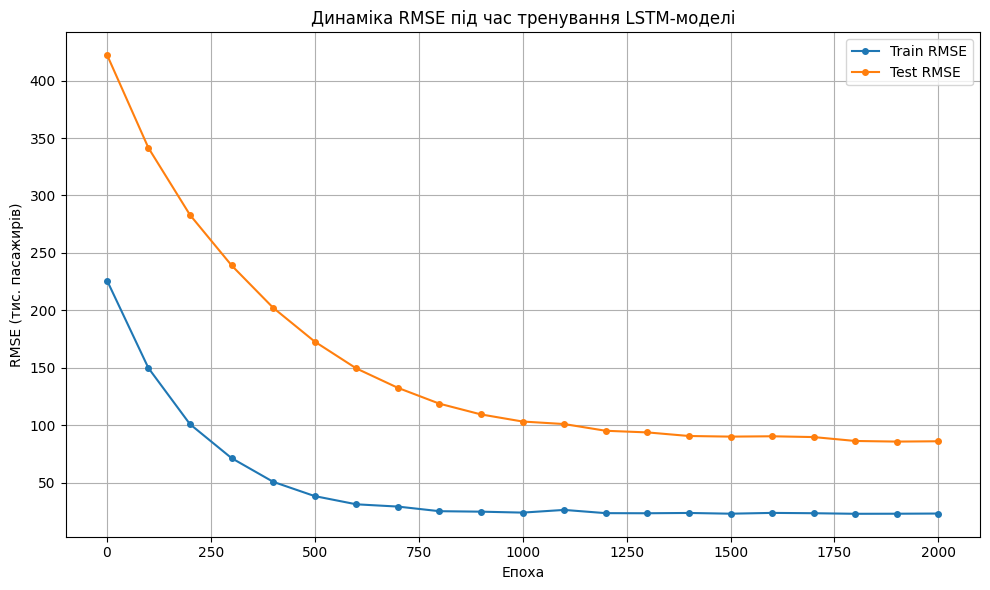

In [52]:
plt.figure(figsize=(10, 6))

plt.plot(epochs_log_100, train_rmse_log_100, label='Train RMSE', marker='o', markersize=4)
plt.plot(epochs_log_100, test_rmse_log_100, label='Test RMSE', marker='o', markersize=4)
plt.title('Динаміка RMSE під час тренування LSTM-моделі')
plt.xlabel('Епоха')
plt.ylabel('RMSE (тис. пасажирів)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Спостереження**

Модель із 100 прихованими вузлами має вищу ємність. Це дозволило їй досягти трохи нижчого Train RMSE (23.1) порівняно з моделлю 50 (24.5). Це означає, що вона стала краще запам'ятовувати шум у тренувальному наборі.

Але, незважаючи на краще запам'ятовування, модель 100 все ще демонструє надзвичайно високу похибку на тестовому наборі (близько 86.0). Це підтверджує:

- Головна проблема не в недостатній ємності моделі, а в попередній обробці даних та неправильному lookback.

- Збільшення hidden_size — це неправильний крок для покращення прогнозів у цьому конкретному випадку без нормалізації та врахування сезонності (lookback > 1).

**Висновок**

Обидві моделі страждають від сильного перенавчання. Для досягнення якісних прогнозів необхідно зупинити подальше збільшення складності та зосередитися на нормалізації даних та використанні більшого вікна lookback.